In [1]:
import shapely
from shapely import Polygon

from osgeo import gdal
import rasterio

import atlite
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
from scipy.constants import physical_constants


In [3]:
weather_excel_path = "Parameters/weather_parameters.xlsx"

weather_parameters = pd.read_excel(weather_excel_path,
                                       index_col = 'Parameters'
                                       ).squeeze('columns')
weather_filename = weather_parameters['Filename']

hexagons = gpd.read_file('Resources/hex_transport.geojson')

cutout = atlite.Cutout('Cutouts_23/' + weather_filename +'.nc')
layout = cutout.uniform_layout()

In [4]:
# location_hydro = gpd.read_file('Data/hydropower_dams.gpkg')
location_hydro = gpd.read_file('Resources\\0Seasonality\\2019\\Data_3\\hydropower_dams.gpkg')
# location_hydro = gpd.read_file('Data/hydropower_dams_EU.gpkg')
# location_hydro = location_hydro[location_hydro["country_code"] != "NO"]
location_hydro.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)
location_hydro.rename(columns={'head_example':'head'},inplace=True)
location_hydro.iloc[:3]

,Name,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,...,Fuel Type,lat,lon,capacity,Domestic Capacity (MW)_y,Expected Generation (GWh),total theoretical possible generation (local) GWh,COD,head,geometry
0,Nam dong,0.621370,0.484299,0.452003,0.303350,0.179800,0.181133,0.183050,0.472720,0.532110,...,Run - Off,19.820458,102.104419,0.89,1.0,5.0,8.76,1970.0,58.0,POINT (102.10442 19.82046)
1,Nam nhon,0.532889,0.368733,0.226214,0.235529,0.135908,0.185300,0.449883,0.706211,0.601605,...,Run - Off,20.427119,100.386111,2.66,3.0,12.0,26.28,2011.0,42.0,POINT (100.38611 20.42712)
2,Nam ko,0.148415,0.085365,0.101035,0.181679,0.193545,0.065672,0.124600,0.150341,0.065905,...,Run - Off,20.792816,102.117246,1.33,1.5,8.0,13.14,1996.0,102.0,POINT (102.11725 20.79282)


In [5]:
laos_hydrobasins = gpd.read_file('data_hydrobasins\\hydrobasins_lvl10/hybas_as_lev10_v1c.shp')
# laos_hydrobasins = gpd.read_file('data_hydrobasins\\hybas_as_lev12_v1c\hybas_as_lev12_v1c.shp')
# laos_hydrobasins = gpd.read_file('data_hydrobasins\\hybas_as_lev08_v1c\\hybas_as_lev08_v1c.shp')
# laos_hydrobasins = gpd.read_file('data_hydrobasins\\hybas_as_lev05_v1c\\hybas_as_lev05_v1c.shp')

# laos_hydrobasins = gpd.read_file('data_hydrobasins\\hybas_eu_lev12_v1c\hybas_eu_lev12_v1c.shp')
# laos_hydrobasins = gpd.sjoin(laos_hydrobasins, location_hydro, how='left', predicate='intersects')

# laos_hydrobasins['lat'] = location_hydro.geometry.y
# laos_hydrobasins['lon'] = location_hydro.geometry.x
laos_hydrobasins.columns
# laos_hydrobasins.to_file('hydrobasins_lvl10/hybas_as_lev10_v1c.gpkg', driver='GPKG')

Index(['HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS', 'DIST_SINK',
       'DIST_MAIN', 'SUB_AREA', 'UP_AREA', 'PFAF_ID', 'ENDO', 'COAST', 'ORDER',
       'SORT', 'geometry'],
      dtype='object')

In [6]:
plant_basin_mapping = gpd.sjoin(location_hydro, laos_hydrobasins, how='left', predicate='intersects')
# print(location_hydro.is_valid.all())  # Should return True
laos_hydrobasins['geometry'] = laos_hydrobasins.buffer(0)
# print(laos_hydrobasins.is_valid.all())  # Should return True

print(plant_basin_mapping.isnull().sum())  # Check for plants with no matching basin

Name                                                 0
Jan                                                  0
Feb                                                  0
Mar                                                  0
Apr                                                  0
May                                                  0
Jun                                                  0
Jul                                                  0
Aug                                                  0
Sep                                                  0
Oct                                                  0
Nov                                                  0
Dec                                                  0
OSeMOSYS tech                                        0
Total capacity (MW)                                  0
Domestic Capacity (MW)_x                             0
Export Capacity (MW)                                 0
SNo                                                  0
New Ose_Na

In [7]:
from shapely.geometry import Point

# Check if each plant intersects any basin
for plant in location_hydro.itertuples():
    point = plant.geometry
    intersecting_basins = laos_hydrobasins[laos_hydrobasins.geometry.intersects(point)]
    if intersecting_basins.empty:
        print(f"Plant at ({plant.lat}, {plant.lon}) does not intersect any basin.")


In [8]:
print("Plants (location_hydro) extent:", location_hydro.total_bounds)
print("Basins (laos_hydrobasins) extent:", laos_hydrobasins.total_bounds)


Plants (location_hydro) extent: [100.3861111  13.944063  107.361188   21.771108 ]
Basins (laos_hydrobasins) extent: [ 57.60833333   1.16666667 150.92148878  55.9375    ]


In [9]:
hydro_profile = cutout.hydro(
    plants=location_hydro,
    hydrobasins= laos_hydrobasins,
    per_unit=True                    # Normalize output per unit area
)

c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\scipy\sparse\_base.py:730: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)


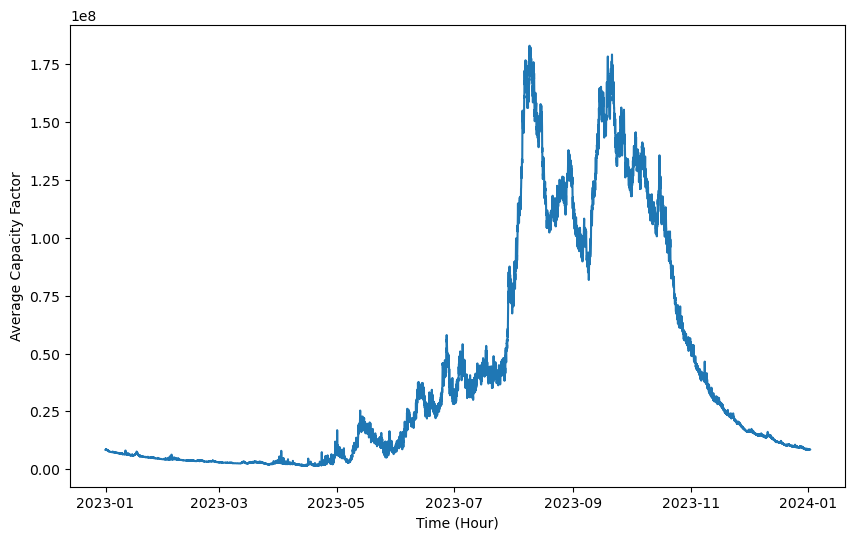

In [10]:
hourly_average = hydro_profile.mean(dim='plant')
plt.figure(figsize=(10, 6))
plt.plot(hourly_average['time'], hourly_average.values)
plt.xlabel('Time (Hour)')
plt.ylabel('Average Capacity Factor')
plt.show()

In [11]:
def hydropower_potential(eta,flowrate,head):
    '''
    Calculate hydropower potential in Megawatts
    eta: Efficiency
    '''
    rho = 997 # kg/m3; Density of water
    g = physical_constants['standard acceleration of gravity'][0] # m/s2; Based on the CODATA constants 2018
    ###########################################################
    # Q = flowrate / 3600
    Q = (flowrate/(1000/24)) / 3600 # transform flowrate per h into flowrate per second
    return (eta * rho * g * Q * head) / (1000 * 1000) # MW


# eta = 0.75 # Value for system efficiency of hydropower - source
# def hydropower_potential_wrapper(flowrate, head):
#     return hydropower_potential(eta, flowrate, head)

# result = xr.apply_ufunc(
#     hydropower_potential_wrapper,
#     hydro_profile,
#     xr.DataArray(location_hydro['head'], dims=['plant']),  # Ensure head values align with plant dimension
#     vectorize=True
# )

In [12]:

# Define the wrapper function to include capacity limiting and capacity factor calculation
def hydropower_potential_with_capacity(flowrate, head, capacity, eta):
    potential = hydropower_potential(flowrate, head, eta)
    limited_potential = xr.where(potential > capacity, capacity, potential)
    capacity_factor = limited_potential / capacity
    return capacity_factor

eta = 0.75 # efficiency of hydropower plant

capacity_factor = xr.apply_ufunc(
    hydropower_potential_with_capacity,
    hydro_profile,
    xr.DataArray(location_hydro['head'].values, dims=['plant']),
    xr.DataArray(location_hydro['capacity'].values, dims=['plant']),
    eta,
    vectorize=True,
    dask='parallelized',  # Dask for parallel computation
    output_dtypes=[float]
)

In [13]:
# Apply a rolling mean to smooth the capacity factor
def smooth_capacity_factor(capacity_factor, window_size=48):
    """
    Smooths the capacity factor data using a rolling mean.
    
    Parameters:
    - capacity_factor: xarray.DataArray, the capacity factor to smooth.
    - window_size: int, the size of the rolling window (in hours).
    
    Returns:
    - Smoothed xarray.DataArray.
    """
    return capacity_factor.rolling(time=window_size, center=True).mean()

window_size = 48  # smoothing window (in hours)
smoothed_capacity_factor = smooth_capacity_factor(capacity_factor, window_size=window_size)


Total number of 1s: 24429
Percentage of 1s: 4.97%


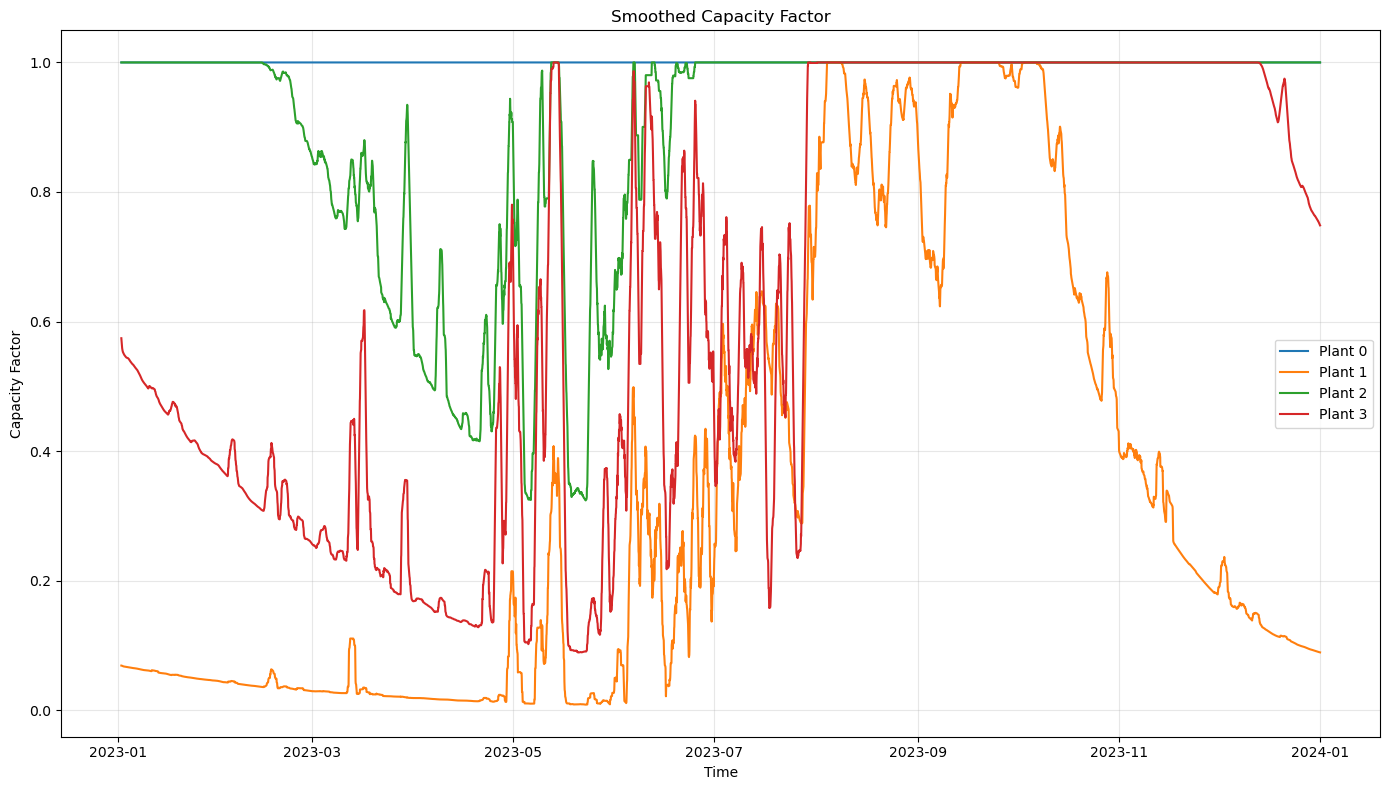

In [14]:

plt.figure(figsize=(14, 8))
for plant in range(4):  # Adjust the range to select plants to visualize
    plt.plot(
        smoothed_capacity_factor['time'], 
        smoothed_capacity_factor.sel(plant=plant), 
        label=f"Plant {plant}"
    )
    
count_ones = (smoothed_capacity_factor == 1).sum().item()
total_values = smoothed_capacity_factor.size
percentage_ones = (count_ones / total_values) * 100

print(f"Total number of 1s: {count_ones}")
print(f"Percentage of 1s: {percentage_ones:.2f}%")

plt.title("Smoothed Capacity Factor")
plt.xlabel("Time")
plt.ylabel("Capacity Factor")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
capacity_factor = smoothed_capacity_factor

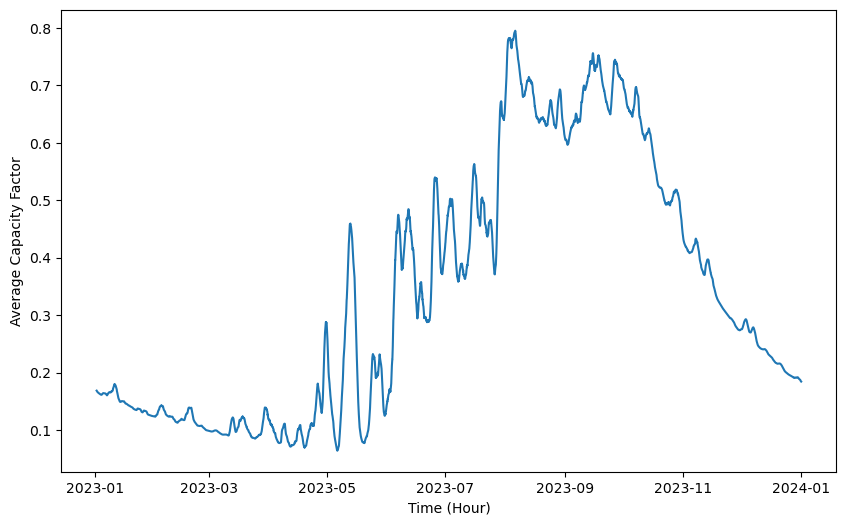

In [16]:
import matplotlib.pyplot as plt

# Calculate the average capacity factor for each hour across all plants
hourly_average = capacity_factor.mean(dim='plant')

# Plot the hourly average capacity factor over time
plt.figure(figsize=(10, 6))

# Plot the hourly average
plt.plot(hourly_average['time'], hourly_average.values)

# Add title and labels
# plt.title('Average Capacity Factor for Each Hour (All Plants)')
plt.xlabel('Time (Hour)')
plt.ylabel('Average Capacity Factor')

# Display the plot
plt.show()

# Optionally, save the plot
# plt.savefig("average_capacity_factor_per_hour.png")


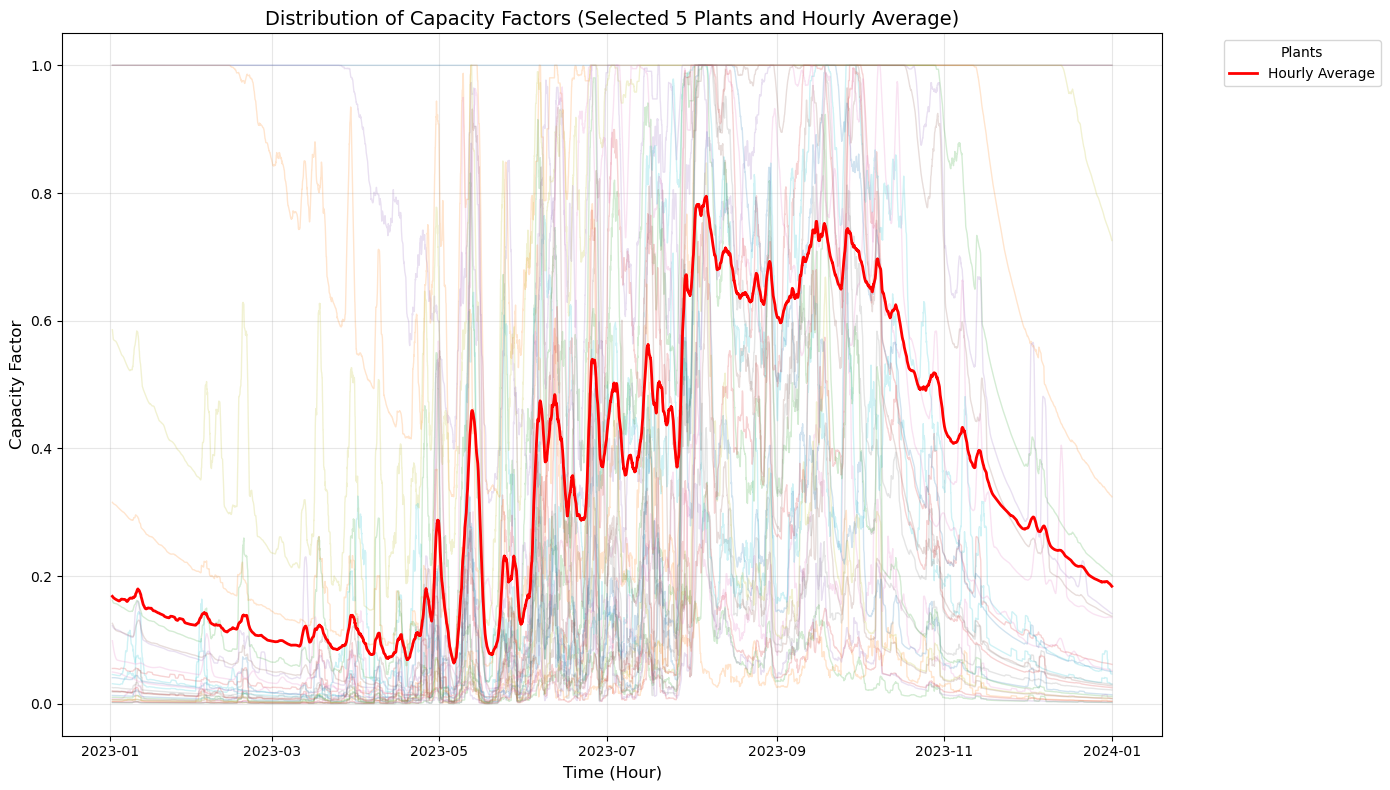

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Function to select diverse plants equally across the range of variability
def select_diverse_plants_equally(capacity_factor, num_plants=30):
    # Calculate the standard deviation of capacity factors for each plant
    plant_variability = capacity_factor.std(dim='time')
    # Number of bins (one for each subset of variability)
    num_bins = 10
    plants_per_bin = num_plants // num_bins
    # Bin the plants based on standard deviation
    bins = np.linspace(plant_variability.min().values, plant_variability.max().values, num_bins + 1)
    selected_plants = []

    for i in range(num_bins):
        # Get plants in the current bin
        bin_indices = (plant_variability >= bins[i]) & (plant_variability < bins[i + 1])
        bin_plants = plant_variability.where(bin_indices, drop=True).plant
        # Randomly select plants_per_bin plants from this bin
        if len(bin_plants) > plants_per_bin:
            selected_plants.extend(np.random.choice(bin_plants.values, plants_per_bin, replace=False))
        else:
            selected_plants.extend(bin_plants.values)

    return selected_plants

# Select 30 diverse plants equally across the range of variability
diverse_plants = select_diverse_plants_equally(capacity_factor, num_plants=30)

# Calculate the average capacity factor for each hour across all plants
hourly_average = capacity_factor.mean(dim='plant')

# Set up the figure and axis
plt.figure(figsize=(14, 8))

# Plot the individual capacity factors for the selected diverse plants with higher transparency
for plant in diverse_plants:
    plt.plot(capacity_factor['time'], capacity_factor.sel(plant=plant), alpha=0.2, linewidth=1, label='_nolegend_')

# Plot the hourly average capacity factor as a bold line
plt.plot(hourly_average['time'], hourly_average.values, color='red', label='Hourly Average', linewidth=2)

# Add title, labels, and legend
plt.title('Distribution of Capacity Factors (Selected 5 Plants and Hourly Average)', fontsize=14)
plt.xlabel('Time (Hour)', fontsize=12)
plt.ylabel('Capacity Factor', fontsize=12)
plt.legend(title="Plants", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Optionally, save the plot to a file
# plt.savefig("capacity_factor_distribution_selected_equally.png", dpi=300)


### Comparison to actual values in 2019 and 2022

In [24]:
# Function to calculate hourly capacity factors for a given year
# def calculate_hourly_capacity_factors(location_hydro):
    # # Initialize an empty DataFrame
    # hourly_capacity_factors = pd.DataFrame()

    # # Iterate over each plant
    # for index, row in location_hydro.iterrows():
    #     plant_name = row['Name']
    #     plant_capacity = row['Total capacity (MW)']  # Plant capacity in MW

    #     # Generate an empty list to hold hourly capacity factors for the plant
    #     plant_hourly_factors = []

    #     # Spread the generation for each month evenly across the respective hours
    #     for month in monthly_columns:
    #         monthly_generation = row[month] * 1000  # Convert GWh to MWh
    #         hourly_generation = monthly_generation / hours_in_month[month]  # MWh per hour
    #         hourly_capacity_factor = hourly_generation / plant_capacity  # Capacity factor

    #         # Repeat this capacity factor for each hour of the month
    #         plant_hourly_factors.extend([hourly_capacity_factor] * hours_in_month[month])

    #     # Add the plant's hourly capacity factors to the DataFrame
    #     hourly_capacity_factors[plant_name] = plant_hourly_factors

    # # Ensure proper time index for the year
    # time_index = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')
    # hourly_capacity_factors.index = time_index

    # return hourly_capacity_factors

def calculate_hourly_capacity_factors(location_hydro):
    # Initialize an empty DataFrame to store smoothed hourly capacity factors
    smoothed_capacity_factors = pd.DataFrame()

    for index, row in location_hydro.iterrows():
        plant_name = row['Name']
        plant_capacity = row['capacity']

        # Generate a time series of monthly averages
        monthly_capacity_factors = []
        for month in monthly_columns:
            monthly_generation = row[month] * 1000  # Convert GWh to MWh
            monthly_capacity_factor = (monthly_generation / hours_in_month[month]) / plant_capacity
            monthly_capacity_factors.append(monthly_capacity_factor)

        # Create a time index for the first day of each month
        monthly_time_index = pd.date_range(start='2023-01-01', end='2024-01-01', freq='MS')[:-1]

        # Create a Series with monthly capacity factors
        monthly_series = pd.Series(data=monthly_capacity_factors, index=monthly_time_index)

        # Interpolate to create hourly data
        hourly_series = monthly_series.resample('h').interpolate(method='cubic')

        # Add the smoothed hourly capacity factors to the DataFrame
        smoothed_capacity_factors[plant_name] = hourly_series

    # Ensure proper time index for the year
    time_index = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='h')
    smoothed_capacity_factors = smoothed_capacity_factors.reindex(time_index)

    return smoothed_capacity_factors


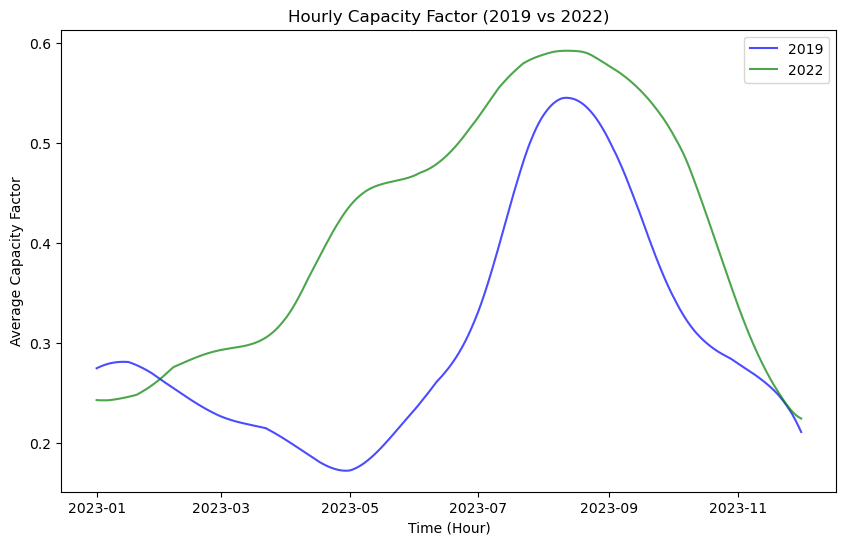

In [25]:

# Load hydropower data for 2019
location_hydro_2019 = gpd.read_file('Resources\\0Seasonality\\2019\\Data_3\\hydropower_dams.gpkg')
location_hydro_2019.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)

# Load hydropower data for 2022
location_hydro_2022 = gpd.read_file('Resources\\0Seasonality\\2022\\Data_2\\hydropower_dams.gpkg')
location_hydro_2022.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)

# Monthly generation columns
monthly_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Hours in each month for the year 2023
hours_in_month = {
    'Jan': 744, 'Feb': 672, 'Mar': 744, 'Apr': 720,
    'May': 744, 'Jun': 720, 'Jul': 744, 'Aug': 744,
    'Sep': 720, 'Oct': 744, 'Nov': 720, 'Dec': 744
}


# Calculate hourly capacity factors for 2019 and 2022
hourly_capacity_factors_2019 = calculate_hourly_capacity_factors(location_hydro_2019)
hourly_capacity_factors_2022 = calculate_hourly_capacity_factors(location_hydro_2022)

###########################
# Cap capacity factors at 1 for 2019
hourly_capacity_factors_2019 = hourly_capacity_factors_2019.clip(lower=0,upper=1)

# Cap capacity factors at 1 for 2022
hourly_capacity_factors_2022 = hourly_capacity_factors_2022.clip(lower=0,upper=1)


# Calculate the hourly average capacity factors across all plants
hourly_average_2019 = hourly_capacity_factors_2019.mean(axis=1)
hourly_average_2022 = hourly_capacity_factors_2022.mean(axis=1)

# Plot the results using hourly data
plt.figure(figsize=(10, 6))

# Plot the 2019 hourly average
plt.plot(hourly_average_2019.index, hourly_average_2019.values, label='2019', color='blue', alpha=0.7)

# Plot the 2022 hourly average
plt.plot(hourly_average_2022.index, hourly_average_2022.values, label='2022', color='green', alpha=0.7)

# Add title and labels
plt.title('Hourly Capacity Factor (2019 vs 2022)')
plt.xlabel('Time (Hour)')
plt.ylabel('Average Capacity Factor')

# Add legend
plt.legend()

# Display the plot
plt.show()


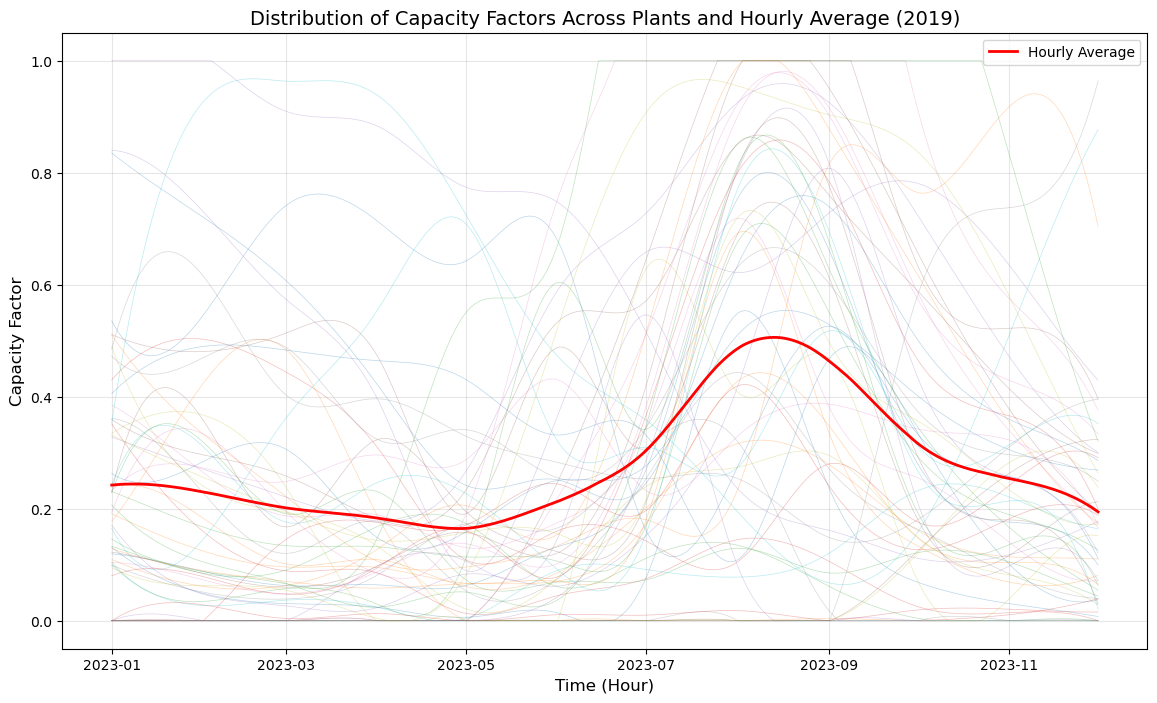

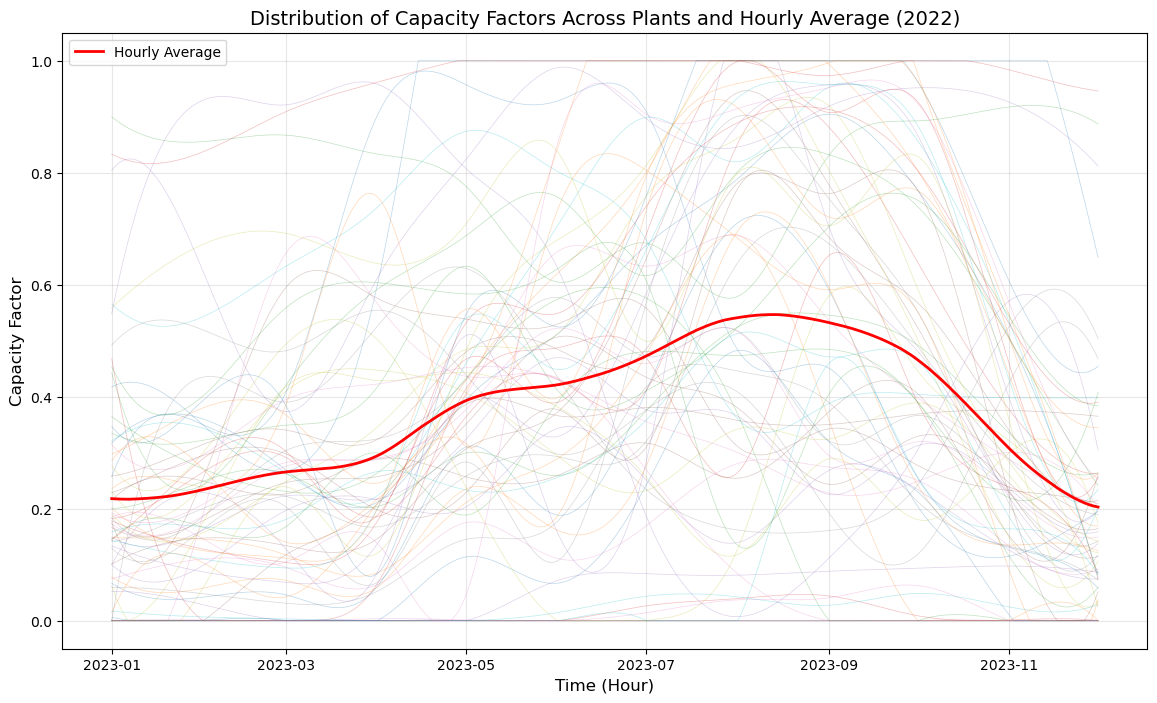

In [272]:
import matplotlib.pyplot as plt

# Function to visualize capacity factors for a single year
def plot_capacity_factors(capacity_factor, year):
    # Calculate the average capacity factor for each hour across all plants
    hourly_average = capacity_factor.mean(axis=1)

    # Set up the figure and axis
    plt.figure(figsize=(14, 8))

    # Plot the individual capacity factors for each plant as transparent lines
    for plant in capacity_factor.columns:
        plt.plot(capacity_factor.index, capacity_factor[plant], alpha=0.3, linewidth=0.5, label='_nolegend_')

    # Plot the hourly average capacity factor as a bold line
    plt.plot(hourly_average.index, hourly_average.values, color='red', label='Hourly Average', linewidth=2)

    # Add title, labels, and legend
    plt.title(f'Distribution of Capacity Factors Across Plants and Hourly Average ({year})', fontsize=14)
    plt.xlabel('Time (Hour)', fontsize=12)
    plt.ylabel('Capacity Factor', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # Display the plot
    plt.show()

    # Optionally, save the plot to a file
    # plt.savefig(f"capacity_factor_distribution_{year}.png", dpi=300)

# Plot for 2019
plot_capacity_factors(hourly_capacity_factors_2019, 2019)

# Plot for 2022
plot_capacity_factors(hourly_capacity_factors_2022, 2022)


In [273]:
# Identify plants with capacity factors above 1
plants_above_1 = hourly_capacity_factors_2019.columns[(hourly_capacity_factors_2019 > 1).any(axis=0)]

# Get the positions (indices) of the plants with values above 1
plants_positions = [hourly_capacity_factors_2019.columns.get_loc(plant) for plant in plants_above_1]

# Filter the `location_hydro` DataFrame by these positions
plants_above_1_info = location_hydro_2019.iloc[plants_positions]

# Add a column to include the maximum capacity factor for each plant
max_capacity_factor = hourly_capacity_factors_2019[plants_above_1].max()
plants_above_1_info['max_capacity_factor'] = max_capacity_factor.values

# Display the resulting DataFrame
print(plants_above_1_info[['SNo','Total capacity (MW)','max_capacity_factor']])

# Optionally, save the result to a CSV file
# plants_above_1_info.to_csv("plants_above_1.csv", index=False)


Empty DataFrame
Columns: [SNo, Total capacity (MW), max_capacity_factor]
Index: []


### COMBINED

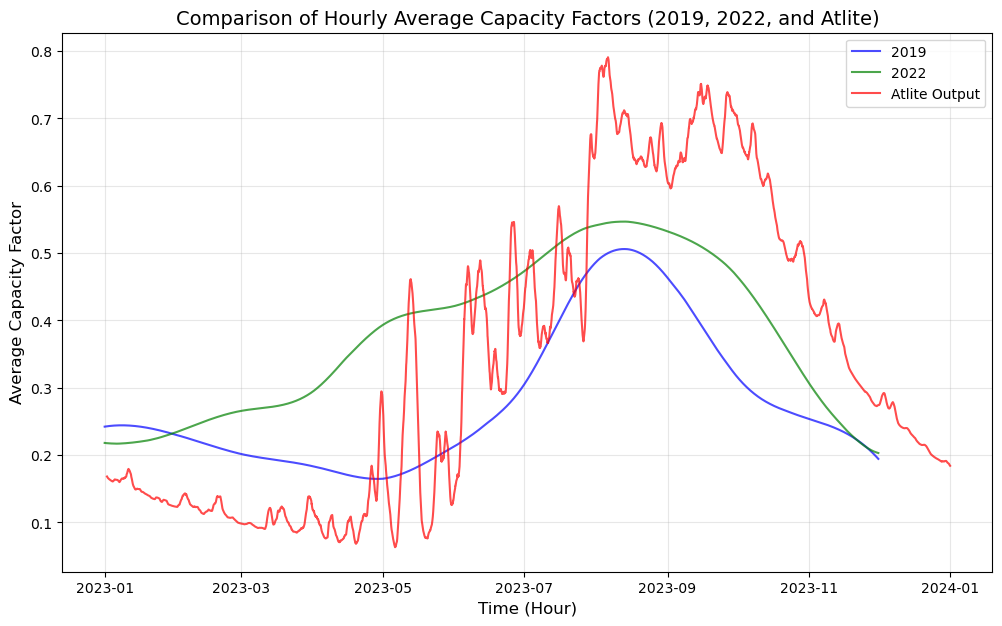

In [287]:
import matplotlib.pyplot as plt

# Calculate the average capacity factor for each hour across all plants
hourly_average_2019 = hourly_capacity_factors_2019.mean(axis=1)
hourly_average_2022 = hourly_capacity_factors_2022.mean(axis=1)
hourly_average_atlite = capacity_factor.mean(dim='plant')  # Assuming capacity_factor is from Atlite output

# Plot the hourly average capacity factor over time
plt.figure(figsize=(12, 7))

# Plot the hourly average for 2019
plt.plot(hourly_average_2019.index, hourly_average_2019.values, label='2019', color='blue', alpha=0.7)

# Plot the hourly average for 2022
plt.plot(hourly_average_2022.index, hourly_average_2022.values, label='2022', color='green', alpha=0.7)

# Plot the Atlite output
plt.plot(hourly_average_atlite['time'], hourly_average_atlite.values, label='Atlite Output', color='red', alpha=0.7)

# Add title and labels
plt.title('Comparison of Hourly Average Capacity Factors (2019, 2022, and Atlite)', fontsize=14)
plt.xlabel('Time (Hour)', fontsize=12)
plt.ylabel('Average Capacity Factor', fontsize=12)

# Add legend
plt.legend()

# Add grid for better visualization
plt.grid(alpha=0.3)

# Display the plot
plt.show()

# Optionally, save the plot
# plt.savefig("capacity_factor_comparison.png", dpi=300)
